In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import pysindy as ps
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sysidentpy.utils.display_results import results
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error, mean_forecast_error

# To have the Matplotlib plots centered in the notebook
from IPython.core.display import HTML
HTML("""
    <style>
    .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
    </style>
    """)

# To ignore UserWarnings
import warnings
warnings.filterwarnings('ignore')

# Import local function
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'src'))

from metrics import get_metrics_df
from narmax.utils import display_nx_model

$$\Large\text{Linear 2D ODE}$$
$$\large \dot{x} = -0.1x + 2y$$
$$\large \dot{y} = -2x - 0.1y$$

$$\large \dot{x} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} x \qquad x \in \R^2$$

$$\large\begin{split}\frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x \\ y\end{bmatrix}\end{split}$$

In [2]:
def f(x, t):
    return [-0.1 * x[0] + 2 * x[1],
            -2 * x[0] - 0.1 * x[1]]

t = np.arange(0, 25, 0.01)
x = odeint(f, [2, 0], t)

# Split Gnerated Data into Train-Test
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.75, shuffle=False)

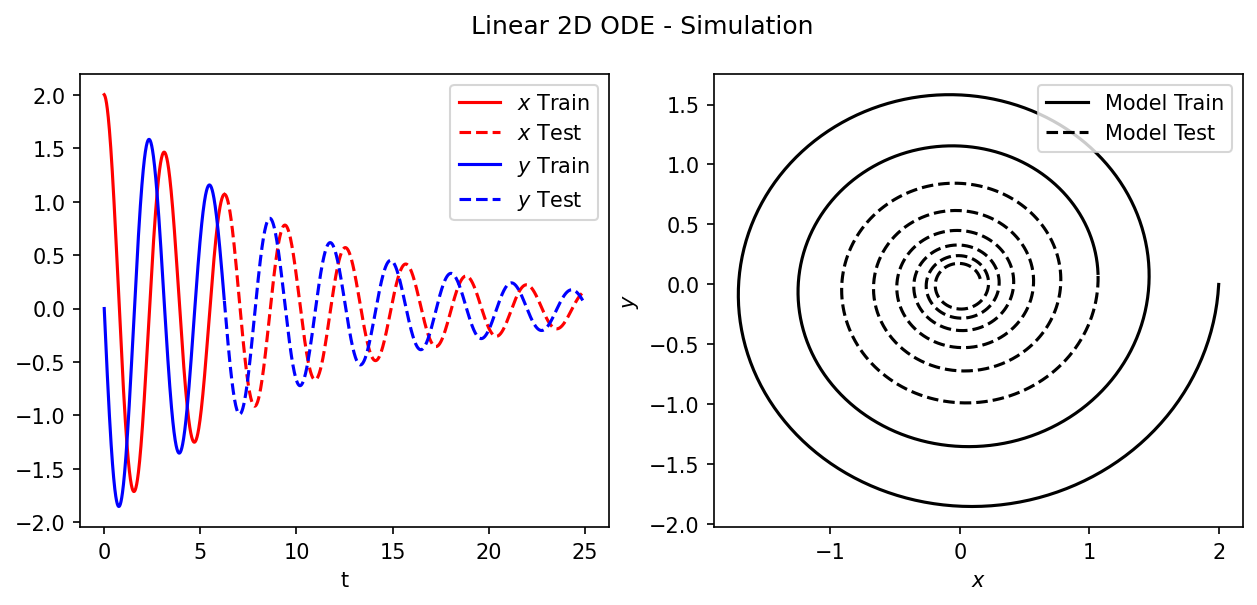

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 2D ODE - Simulation')
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [4]:
# Define SINDy Model
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['x', 'y']
)
# Fit model and get time taken
tic = time.time()
sindy_model.fit(x_train, t=t_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(x_test[0], t_test)

x' = -0.100 x + 2.000 y
y' = -2.000 x + -0.100 y


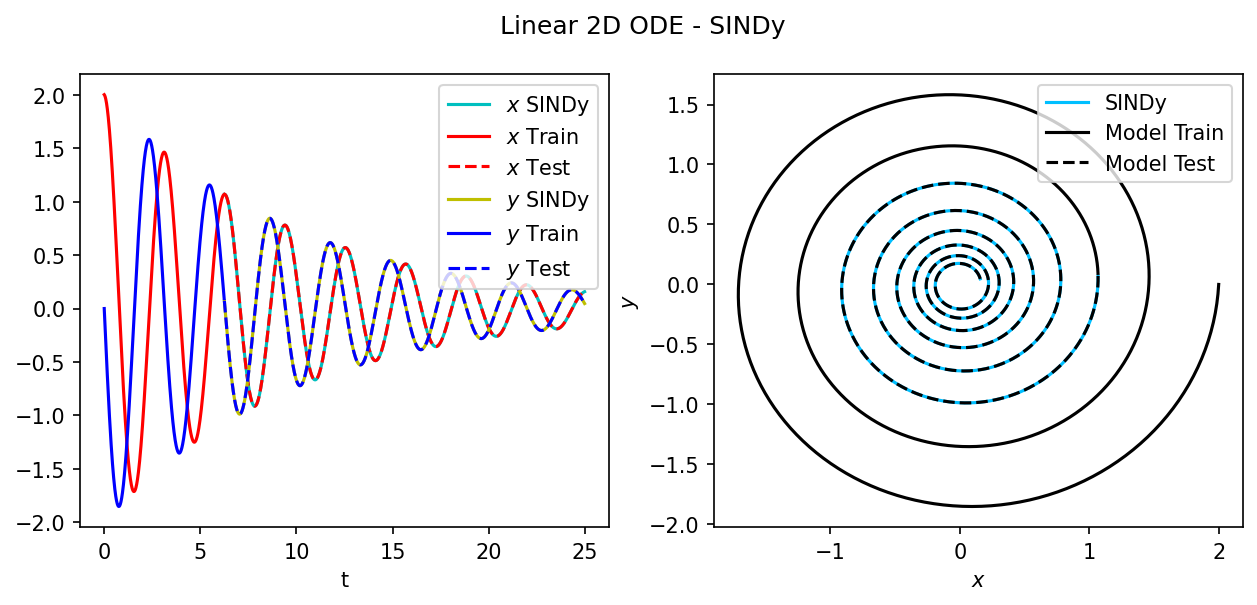

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 2D ODE - SINDy')
axs[0].plot(t_test, sindy_sim[:, 0], "c", label="$x$ SINDy")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, sindy_sim[:, 1], "y", label="$y$ SINDy")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(sindy_sim[:, 0], sindy_sim[:, 1], "deepskyblue", label="SINDy")
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [6]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=1,
    estimator='least_squares',
    basis_function=Polynomial(degree=5)
)
# Train model for the state Y and get time
tic = time.time()
nx_model.fit(X=x_train[:-1,0].reshape(-1, 1), y=x_train[1:,1].reshape(-1, 1))
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state Y and print
coeffs_y = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'y', ['x'])
# Simulate model for the state Y
sim_y = nx_model.predict(X=x_test[:,0].reshape(-1, 1), y=x_test[0,1].reshape(-1, 1))

# Train Model for the state X and get time
tic = time.time()
nx_model.fit(X=x_train[:-1,1].reshape(-1, 1), y=x_train[1:,0].reshape(-1, 1))
toc = time.time()
narmax_time += toc - tic
# Get model parameters for the state X and print
coeffs_x = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'x', ['y'])
# Simulate model for the state X
sim_x = nx_model.predict(X=x_test[:,1].reshape(-1, 1), y=x_test[0,0].reshape(-1, 1))

# Stack results for models and predictions
narmax_model = np.vstack((coeffs_x, coeffs_y))
narmax_sim = np.hstack((sim_x, sim_y))

y(k) = 9.984E-01 y(k-1) + -1.996E-02 x(k-1) + -9.432E-10 y(k-1)^3 + 4.287E-11 x(k-1)^4 + 1.765E-10 y(k-1)^5
x(k) = 9.984E-01 x(k-1) + 1.996E-02 x(k-1) + -2.342E-10 x(k-1)^3x(k-1)^2 + -2.646E-11 x(k-1)^4 + -1.862E-11 x(k-1)^4


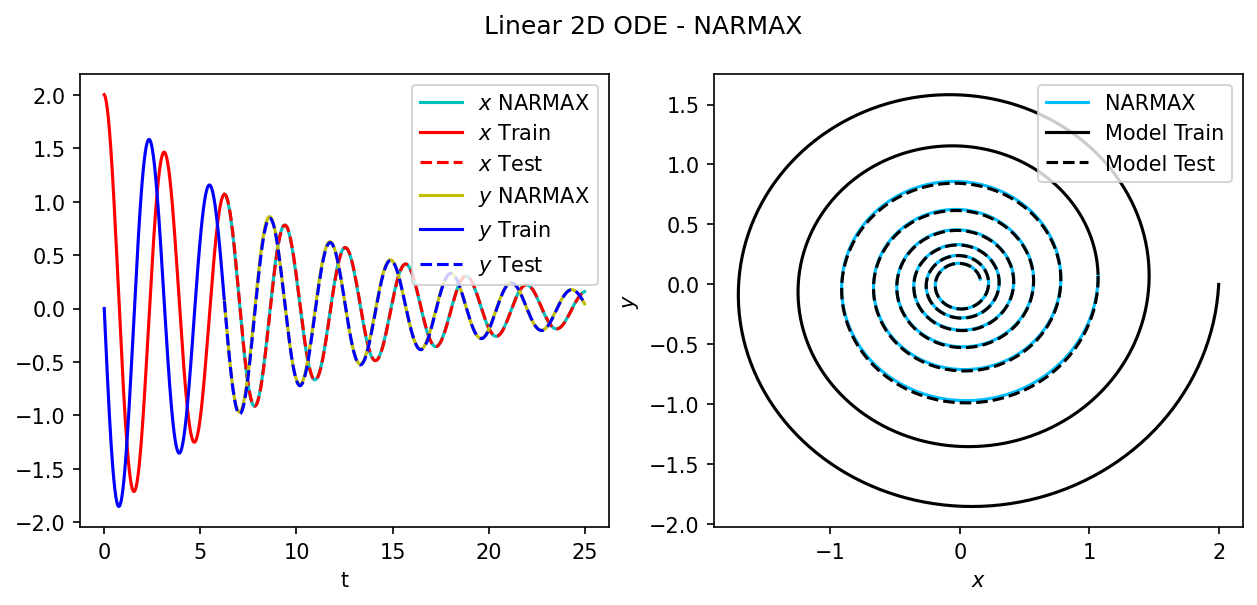

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 2D ODE - NARMAX')
axs[0].plot(t_test, narmax_sim[:, 0], "c", label="$x$ NARMAX")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, narmax_sim[:, 1], "y", label="$y$ NARMAX")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(narmax_sim[:, 0], narmax_sim[:, 1], "deepskyblue", label="NARMAX")
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [8]:
# Metrics (PENDING!!!)

$$\Large\text{Cubic 2D ODE}$$
$$\large \dot{x} = -0.1x^3 + 2y^3$$
$$\large \dot{y} = -2x^3 - 0.1y^3$$

$$\large \dot{x} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} x^3 \qquad x \in \R^2$$

$$\large\begin{split}\frac{d}{dt}\begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}-0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x^3 \\ y^3\end{bmatrix}\end{split}$$

In [9]:
def f(x, t):
    return [-0.1 * x[0]**3 + 2 * x[1]**3,
            -2 * x[0]**3 - 0.1 * x[1]**3]

t = np.arange(0, 25, 0.001)
x = odeint(f, [2, 0], t)

# Split Gnerated Data into Train-Test
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.75, shuffle=False)

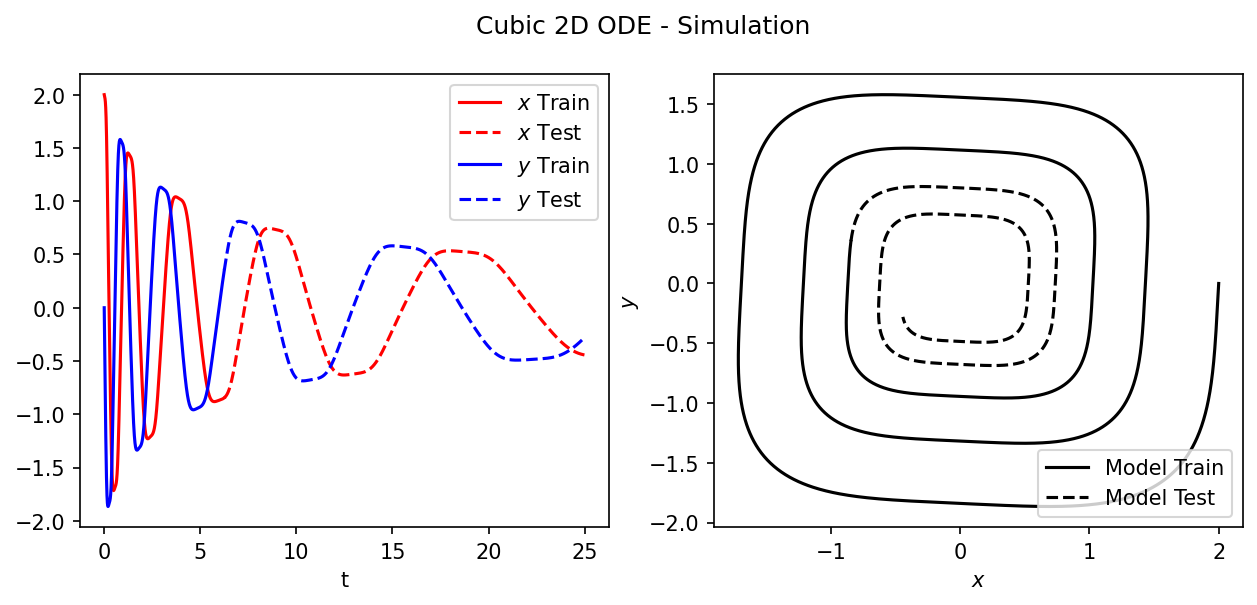

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Cubic 2D ODE - Simulation')
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [11]:
# Define SINDy Model
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['x', 'y']
)
# Fit model and get time taken
tic = time.time()
sindy_model.fit(x_train, t=t_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(x_test[0], t_test)

x' = -0.100 x^3 + 2.000 y^3
y' = -2.000 x^3 + -0.100 y^3


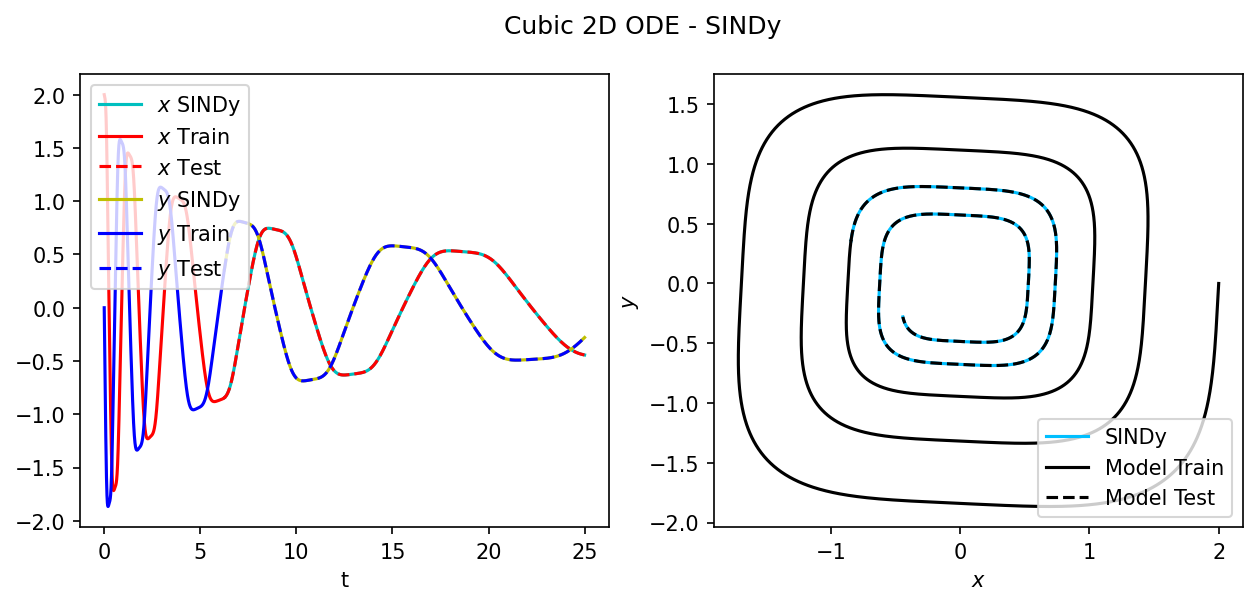

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Cubic 2D ODE - SINDy')
axs[0].plot(t_test, sindy_sim[:, 0], "c", label="$x$ SINDy")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, sindy_sim[:, 1], "y", label="$y$ SINDy")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(sindy_sim[:, 0], sindy_sim[:, 1], "deepskyblue", label="SINDy")
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [13]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=1,
    estimator='least_squares',
    basis_function=Polynomial(degree=5)
)
# Train model for the state Y and get time
tic = time.time()
nx_model.fit(X=x_train[:-1,0].reshape(-1, 1), y=x_train[1:,1].reshape(-1, 1))
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state Y and print
coeffs_y = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'y', ['x'])
# Simulate model for the state Y
sim_y = nx_model.predict(X=x_test[:,0].reshape(-1, 1), y=x_test[0,1].reshape(-1, 1))

# Train Model for the state X and get time
tic = time.time()
nx_model.fit(X=x_train[:-1,1].reshape(-1, 1), y=x_train[1:,0].reshape(-1, 1))
toc = time.time()
narmax_time += toc - tic
# Get model parameters for the state X and print
coeffs_x = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'x', ['y'])
# Simulate model for the state X
sim_x = nx_model.predict(X=x_test[:,1].reshape(-1, 1), y=x_test[0,0].reshape(-1, 1))

# Stack results for models and predictions
narmax_model = np.vstack((coeffs_x, coeffs_y))
narmax_sim = np.hstack((sim_x, sim_y))

y(k) = 1.000E+00 y(k-1) + -2.000E-03 x(k-1)^3 + -1.000E-04 y(k-1)^3 + -1.797E-05 x(k-1)^2y(k-1)^3 + 8.937E-07 x(k-1)^5 + 2.480E-07 x(k-1)^3y(k-1)^2 + -2.142E-07 x(k-1)y(k-1)^4 + 1.912E-07 x(k-1)y(k-1)^2 + 1.811E-08 x(k-1)y(k-1)^3 + 1.864E-08 y(k-1)^5
x(k) = 1.000E+00 x(k-1) + 2.000E-03 x(k-1)^3 + -9.997E-05 x(k-1)^3 + -1.798E-05 x(k-1)^2x(k-1)^3 + -8.835E-07 x(k-1)^5 + -2.376E-07 x(k-1)^3x(k-1)^2 + 2.277E-07 x(k-1)x(k-1)^4 + -2.428E-07 x(k-1)x(k-1)^2 + -6.772E-09 x(k-1)^4 + 6.027E-08 x(k-1)


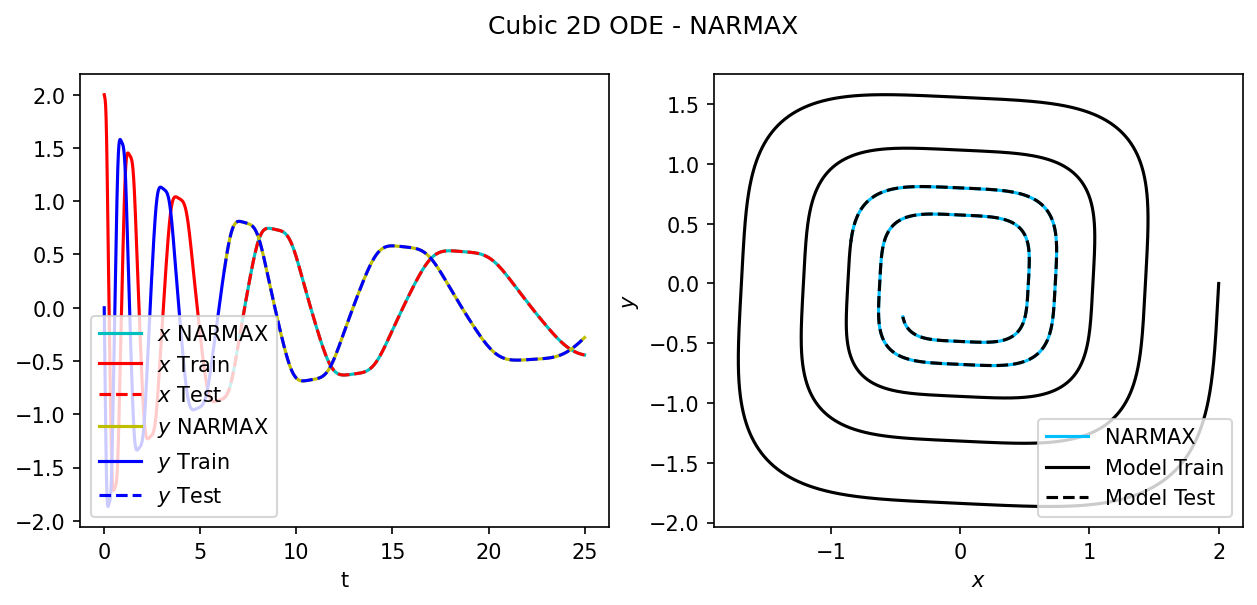

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Cubic 2D ODE - NARMAX')
axs[0].plot(t_test, narmax_sim[:, 0], "c", label="$x$ NARMAX")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, narmax_sim[:, 1], "y", label="$y$ NARMAX")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(narmax_sim[:, 0], narmax_sim[:, 1], "deepskyblue", label="NARMAX")
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [15]:
# Metrics DataFrame
get_metrics_df(x_test, [2, 2], sindy_model, narmax_model, sindy_sim, narmax_sim, sindy_time, narmax_time)

,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,R2 Score,Time
SINDy,"[2.0, 2.0]","[0.0, 0.0]",4.0,-0.000002,7.990085e-11,0.000019,1.000000,0.008595
NARMAX,"[10.0, 10.0]","[8.0, 8.0]",20.0,0.000335,3.406687e-07,0.001244,0.999999,0.207832


$$\Large\text{Linear 3D ODE}$$
$$\large \dot{x} = -0.1x + 2y$$
$$\large \dot{y} = -2x - 0.1y$$
$$\large \dot{z} = -0.3z$$

$$\large \dot{x} = \begin{bmatrix} -0.1 & 2 & 0\\ -2 & -0.1 & 0\\ 0 & 0 & -0.3\end{bmatrix} x \qquad x \in \R^2$$

$$\large\begin{split}\frac{d}{dt}\begin{bmatrix}x \\ y \\ z \end{bmatrix} = \begin{bmatrix}-0.1 & -2 & 0 \\ 2 & -0.1 & 0 \\ 0 & 0 & -0.3 \end{bmatrix} \begin{bmatrix}x \\ y \\ z \end{bmatrix}\end{split}$$

In [16]:
def f(x, t):
    return [-0.1 * x[0] + 2 * x[1],
            -2 * x[0] - 0.1 * x[1],
            -0.3 * x[2]]

t = np.arange(0, 50, 0.01)
x = odeint(f, [2, 0, 1], t)

# Split Gnerated Data into Train-Test
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.6, shuffle=False)

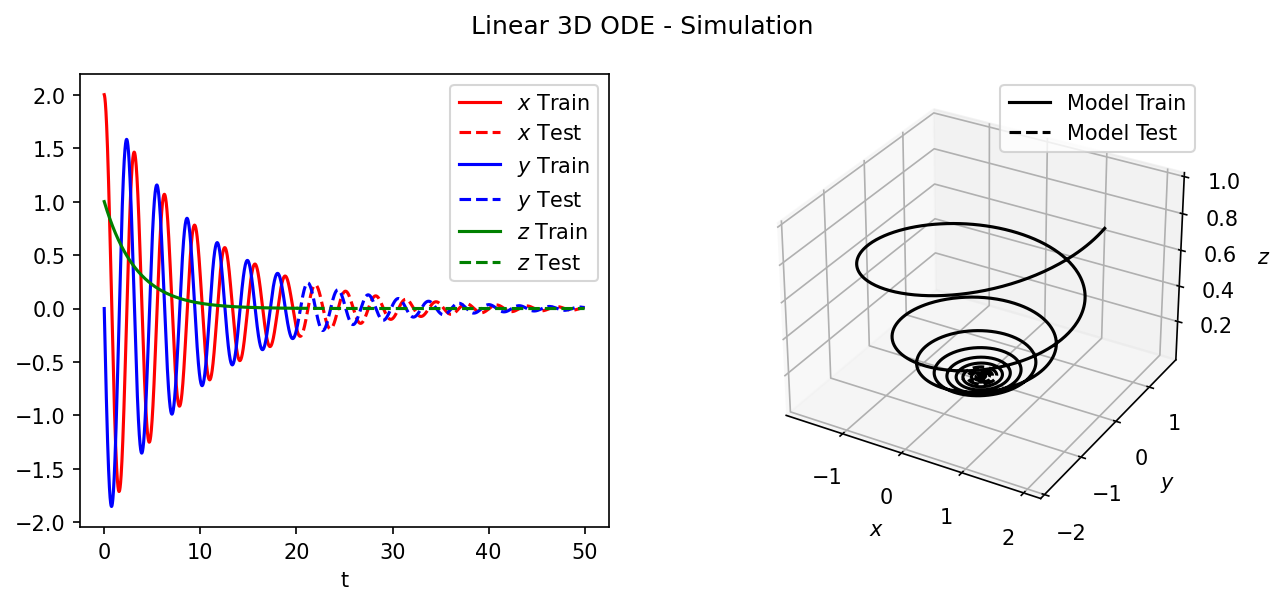

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 3D ODE - Simulation')
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [18]:
# Define SINDy Model
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.01),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['x', 'y', 'z']
)
# Fit model and get time taken
tic = time.time()
sindy_model.fit(x_train, t=t_train, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(x_test[0], t_test)

x' = -0.100 x + 2.000 y
y' = -2.000 x + -0.100 y
z' = -0.300 z


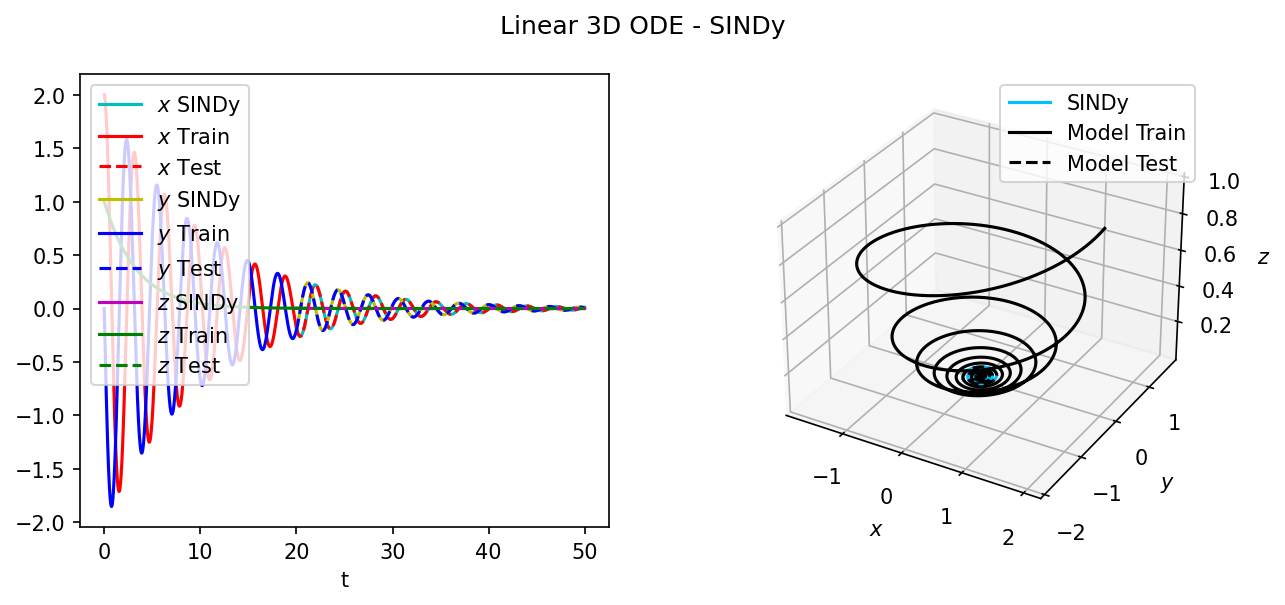

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 3D ODE - SINDy')
axs[0].plot(t_test, sindy_sim[:, 0], "c", label="$x$ SINDy")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, sindy_sim[:, 1], "y", label="$y$ SINDy")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_test, sindy_sim[:, 2], "m", label="$z$ SINDy")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(sindy_sim[:, 0], sindy_sim[:, 1], sindy_sim[:, 2], "deepskyblue", label="SINDy")
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [20]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    n_terms=3,
    info_criteria='bic',
    ylag=1, xlag=[[1],[1]],
    estimator='least_squares',
    basis_function=Polynomial(degree=5)
)
# Train model for the state Z and get time
tic = time.time()
nx_model.fit(X=x_train[:-1,:2], y=x_train[1:,2].reshape(-1, 1))
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state Z and print
coeffs_z = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'z', ['x', 'y'])
# Simulate model for the state Z
sim_z = nx_model.predict(X=x_test[:,:2], y=x_test[0,2].reshape(-1, 1))

# Train model for the state Y and get time
tic = time.time()
nx_model.fit(X=x_train[:-1,[0,2]], y=x_train[1:,1].reshape(-1, 1))
toc = time.time()
narmax_time += toc - tic
# Get model parameters for the state Y and print
coeffs_y = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'y', ['x', 'z'])
# Simulate model for the state Y
sim_y = nx_model.predict(X=x_test[:,[0,2]], y=x_test[0,1].reshape(-1, 1))

# Train Model for the state X and get time
tic = time.time()
nx_model.fit(X=x_train[:-1,1:], y=x_train[1:,0].reshape(-1, 1))
toc = time.time()
narmax_time += toc - tic
# Get model parameters for the state X and print
coeffs_x = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'x', ['y', 'z'])
# Simulate model for the state X
sim_x = nx_model.predict(X=x_test[:,1:], y=x_test[0,0].reshape(-1, 1))

# Stack results for models and predictions
narmax_model = np.vstack((coeffs_x, coeffs_y, coeffs_z))
narmax_sim = np.hstack((sim_x, sim_y, sim_z))

z(k) = 9.970E-01 z(k-1) + -1.339E-15 z(k-1)^2x(k-1)^2z(k-1) + -4.251E-16 z(k-1)x(k-1)^2z(k-1)^2
y(k) = 9.984E-01 y(k-1) + -1.996E-02 x(k-1) + -1.699E-10 z(k-1)y(k-1)^3
x(k) = 9.984E-01 x(k-1) + 1.996E-02 x(k-1) + -1.749E-10 x(k-1)^3x(k-1)^2


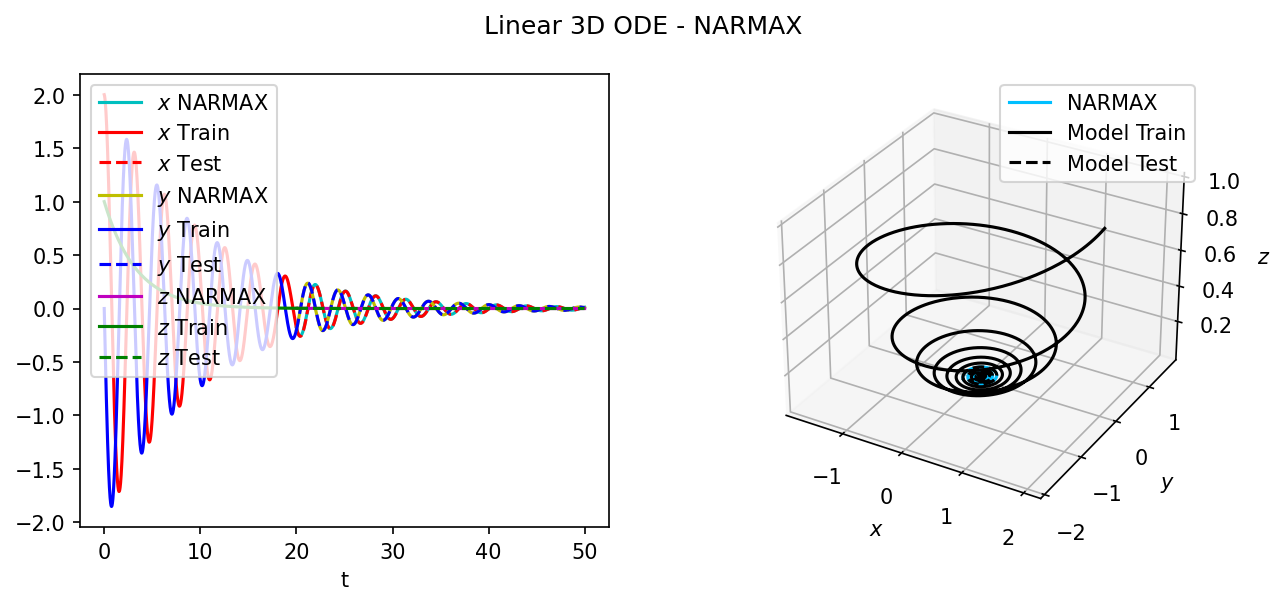

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 3D ODE - NARMAX')
axs[0].plot(t_test, narmax_sim[:, 0], "c", label="$x$ NARMAX")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, narmax_sim[:, 1], "y", label="$y$ NARMAX")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_test, narmax_sim[:, 2], "m", label="$z$ NARMAX")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(narmax_sim[:, 0], narmax_sim[:, 1], narmax_sim[:, 2], "deepskyblue", label="NARMAX")
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [22]:
# Metrics DataFrame
get_metrics_df(x_test, [2, 2, 1], sindy_model, narmax_model, sindy_sim, narmax_sim, sindy_time, narmax_time)

,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,R2 Score,Time
SINDy,"[2.0, 2.0, 1.0]","[0.0, 0.0, 0.0]",5.0,3.978070e-07,3.407523e-09,0.000916,0.999999,0.034045
NARMAX,"[3.0, 3.0, 3.0]","[1.0, 1.0, 2.0]",9.0,-4.206064e-05,2.603573e-06,0.025394,0.999573,0.316919


$$\Large\text{Lorenz System}$$
$$\large \begin{split} \dot{x} & = \sigma(y-x)\\\dot{y} & = x(\rho - z) - y\\\dot{z} & = xy-\beta z\end{split}\\\large\sigma = 10 \qquad \rho = 28 \qquad \beta = \frac{8}{3}$$

In [23]:
# Lorenz System
sigma = 10
rho = 28
beta = 8/3

def lorenz(x, t):
    return [sigma * (x[1] - x[0]),
            x[0] * (rho - x[2]) - x[1],
            x[0] * x[1] - beta * x[2]]

t = np.arange(0, 25, 0.0005)
x = odeint(lorenz, [-8, 8, 27], t)

# Split Gnerated Data into Train-Test
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.75, shuffle=False)

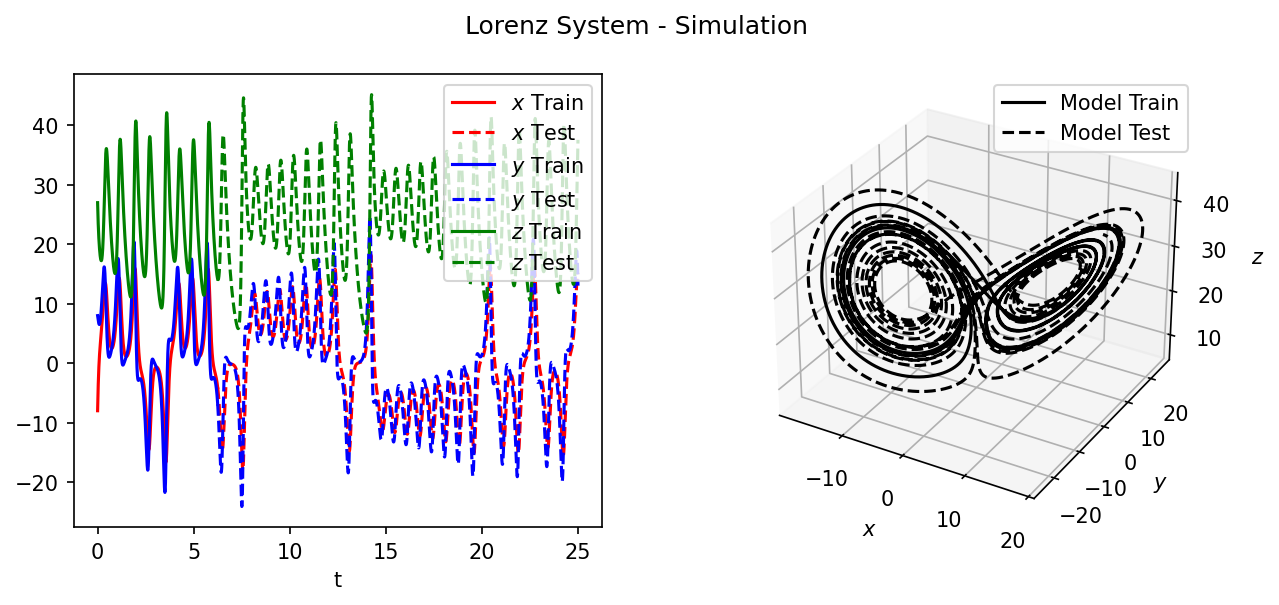

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Lorenz System - Simulation')
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [25]:
# Define SINDy Model
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.01),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['x', 'y', 'z']
)
# Fit and print resulting model
sindy_model.fit(x_train, t=t_train, quiet=True)
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(x_test[0], t_test)

x' = -10.000 x + 10.000 y
y' = 28.000 x + -1.000 y + -1.000 x z
z' = -2.667 z + 1.000 x y


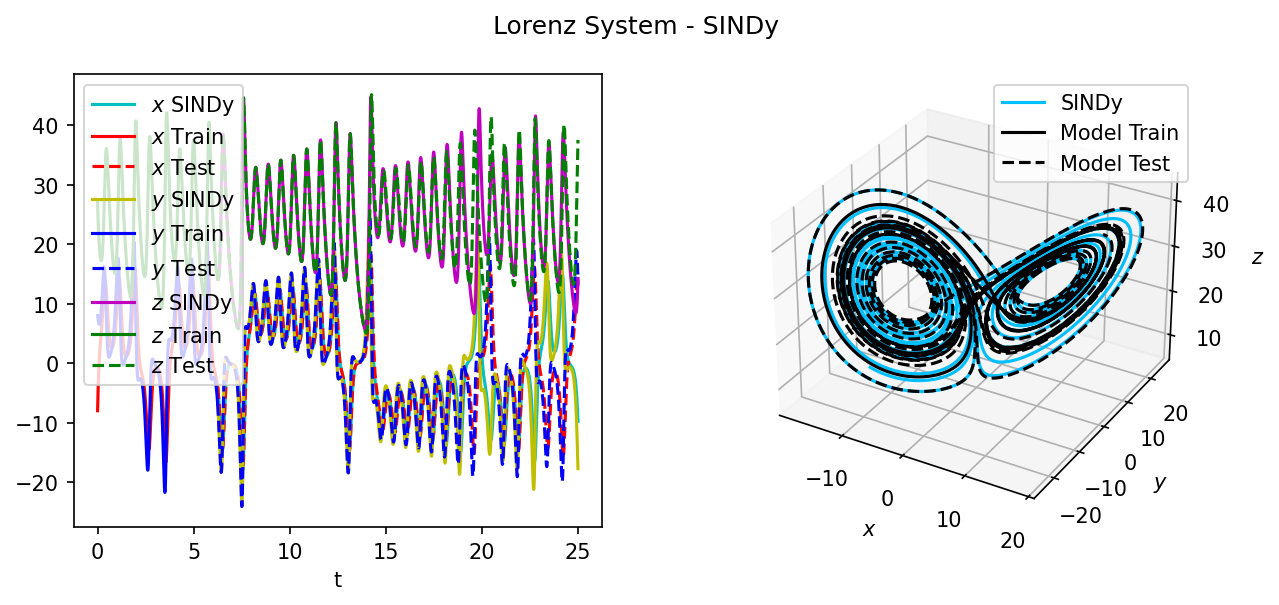

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Lorenz System - SINDy')
axs[0].plot(t_test, sindy_sim[:, 0], "c", label="$x$ SINDy")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, sindy_sim[:, 1], "y", label="$y$ SINDy")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_test, sindy_sim[:, 2], "m", label="$z$ SINDy")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(sindy_sim[:, 0], sindy_sim[:, 1], sindy_sim[:, 2], "deepskyblue", label="SINDy")
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [27]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=[[1],[1]],
    estimator='least_squares',
    basis_function=Polynomial(degree=5)
)
# Train model for the state Z and get time
tic = time.time()
nx_model.fit(X=x_train[:-1,:2], y=x_train[1:,2].reshape(-1, 1))
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state Z and print
coeffs_z = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'z', ['x', 'y'])
# Simulate model for the state Z
sim_z = nx_model.predict(X=x_test[:,:2], y=x_test[0,2].reshape(-1, 1))

# Train model for the state Y and get time
tic = time.time()
nx_model.fit(X=x_train[:-1,[0,2]], y=x_train[1:,1].reshape(-1, 1))
toc = time.time()
narmax_time += toc - tic
# Get model parameters for the state Y and print
coeffs_y = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'y', ['x', 'z'])
# Simulate model for the state Y
sim_y = nx_model.predict(X=x_test[:,[0,2]], y=x_test[0,1].reshape(-1, 1))

# Train Model for the state X and get time
tic = time.time()
nx_model.fit(X=x_train[:-1,1:], y=x_train[1:,0].reshape(-1, 1))
toc = time.time()
narmax_time += toc - tic
# Get model parameters for the state X and print
coeffs_x = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'x', ['y', 'z'])
# Simulate model for the state X
sim_x = nx_model.predict(X=x_test[:,1:], y=x_test[0,0].reshape(-1, 1))

# Stack results for models and predictions
narmax_model = np.vstack((coeffs_x, coeffs_y, coeffs_z))
narmax_sim = np.hstack((sim_x, sim_y, sim_z))

z(k) = 9.987E-01 z(k-1) + 4.957E-04 z(k-1)x(k-1) + 1.564E-13 x(k-1)^2z(k-1)^2 + 3.729E-06 z(k-1)^2 + 3.556E-12 x(k-1)^4 + -5.821E-09 z(k-1)x(k-1)z(k-1) + 1.037E-05 x(k-1)^2 + -3.704E-07 x(k-1)^2z(k-1) + 4.544E-11 z(k-1)x(k-1)^3 + -1.049E-13 z(k-1)^2x(k-1)^2z(k-1)
y(k) = 9.996E-01 y(k-1) + -9.456E-12 z(k-1)x(k-1)^3 + -1.622E-12 x(k-1)^5 + -3.727E-06 z(k-1)y(k-1) + -1.532E-14 z(k-1)^4x(k-1) + 1.389E-02 x(k-1) + -4.951E-04 z(k-1)x(k-1) + -3.702E-07 x(k-1)^2y(k-1) + -4.116E-09 x(k-1)y(k-1)^2 + -2.980E-10 z(k-1)^2x(k-1)
x(k) = 9.951E-01 x(k-1) + 4.984E-03 x(k-1) + -3.740E-06 z(k-1)x(k-1) + -1.450E-09 x(k-1)x(k-1)^2 + 4.152E-09 z(k-1)x(k-1) + 1.395E-15 z(k-1)^4x(k-1) + -4.665E-15 z(k-1)^2x(k-1)^3 + -7.185E-12 z(k-1)^2x(k-1) + 2.297E-14 x(k-1)x(k-1)^4 + -4.325E-15 x(k-1)^4


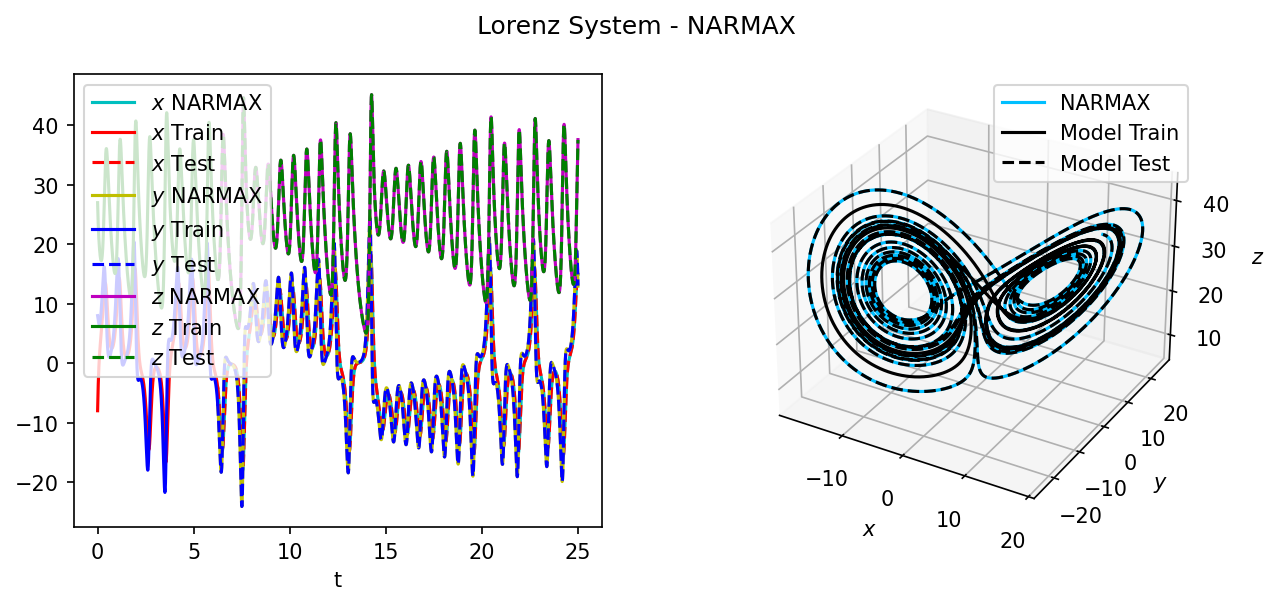

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Lorenz System - NARMAX')
axs[0].plot(t_test, narmax_sim[:, 0], "c", label="$x$ NARMAX")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, narmax_sim[:, 1], "y", label="$y$ NARMAX")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_test, narmax_sim[:, 2], "m", label="$z$ NARMAX")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(narmax_sim[:, 0], narmax_sim[:, 1], narmax_sim[:, 2], "deepskyblue", label="NARMAX")
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [29]:
# Metrics DataFrame
get_metrics_df(x_test, [2, 3, 2], sindy_model, narmax_model, sindy_sim, narmax_sim, sindy_time, narmax_time)

,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,R2 Score,Time
SINDy,"[2.0, 3.0, 2.0]","[0.0, 0.0, 0.0]",7.0,-0.116566,47.042059,0.814473,0.344619,0.034045
NARMAX,"[10.0, 10.0, 10.0]","[8.0, 7.0, 8.0]",30.0,-0.001051,0.000958,0.003667,0.999987,1.736738
